# **Riesgo de Mercado en Python**
## **Pipeline: Retornos → ARIMA (media) → GARCH (volatilidad condicional) → Forecast → VaR**

**Objetivo:** estimar y proyectar volatilidad condicional con enfoque profesional (separación media/varianza) como base para VaR dinámico.

---

### **Mapa del notebook (secuencia)**
1. Gestión de datos y retornos  
2. Estacionariedad y diagnóstico básico  
3. Modelo de media (ARIMA) + residuos  
4. Evidencia ARCH (clustering)  
5. Modelos GARCH/EGARCH/GJR + distribuciones  
6. Diagnóstico del modelo (residuos estandarizados)  
7. Forecast de volatilidad (horizonte H)  
8. Modelamiento VaR y Backtesting



# **1. Gestión de Datos Financieros**


# **2. Series de Tiempo: Estacionariedad y Modelo de Media (ARIMA)**


## BLOQUE 1 — Datos y transformaciones

- Descarga de datos (Close)
- Construcción de **log-precio** y **log-retornos**
- Plots rápidos de sanity check

In [1]:
# ================================
# BLOQUE 1 — LIBRERÍAS + PARÁMETROS
# ================================
import warnings
warnings.filterwarnings("ignore")

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

# Parámetros
ticker = "CHILE.SN"       
start  = "2015-01-01"
end    = None             # None = hasta hoy

import pmdarima as pm


In [2]:
# ================================
# BLOQUE 1 — DESCARGA + LIMPIEZA
# ================================
df = yf.download(ticker, start=start, end=end, auto_adjust=False, progress=False)

# Normalizar índice (Datetime), ordenar y limpiar
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df = df.dropna()

df.head()


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,CHILE.SN,CHILE.SN,CHILE.SN,CHILE.SN,CHILE.SN,CHILE.SN
Date,,,,,,
2015-01-02,37.205578,62.646618,63.297421,62.584209,62.691193,12005283
2015-01-05,36.824364,62.004726,63.341995,61.737274,62.646618,78739801
2015-01-06,36.681408,61.764019,62.138454,61.692696,62.004726,46147913
2015-01-07,36.755535,61.888828,62.396992,61.719440,61.764019,79012919
2015-01-08,36.930252,62.183029,62.307842,61.960152,61.888828,40117024


In [3]:
# ================================
# BLOQUE 1 — PRECIOS → LOG-RETORNOS
# ================================
# Nota (buenas prácticas):
# Para análisis de retornos/volatilidad/VaR se recomienda usar 'Adj Close'
# (ajustado por dividendos y splits) para evitar saltos artificiales.
USE_ADJ_CLOSE = True
price_col = "Adj Close" if (USE_ADJ_CLOSE and "Adj Close" in df.columns) else "Close"

# Serie de precio
price = df[price_col].copy()
price.name = "price"

# Log-precio y log-retornos
log_price = np.log(price)
log_ret = log_price.diff().dropna()
log_ret.name = "log_ret"

print("Price column:", price_col)
print("Obs price:", price.shape[0])
print("Obs log_ret:", log_ret.shape[0])
log_ret.head()


Price column: Adj Close
Obs price: 2774
Obs log_ret: 2773


Ticker,CHILE.SN
Date,
2015-01-05,-0.010299
2015-01-06,-0.003890
2015-01-07,0.002019
2015-01-08,0.004742
2015-01-09,-0.003159


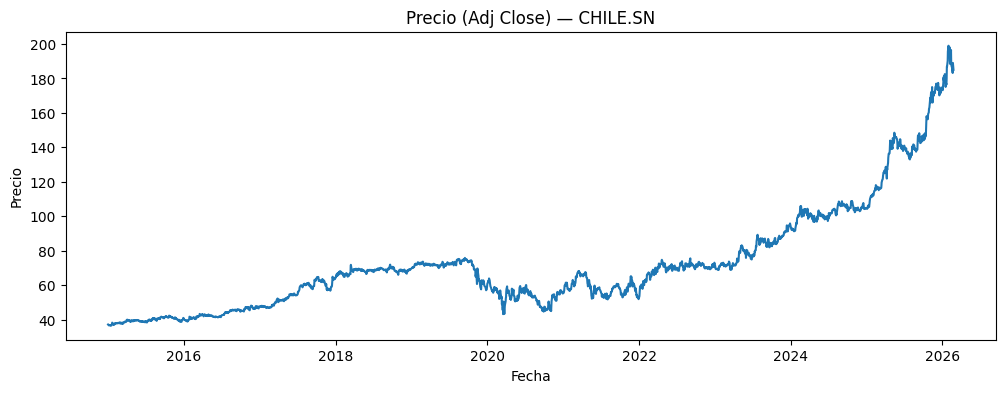

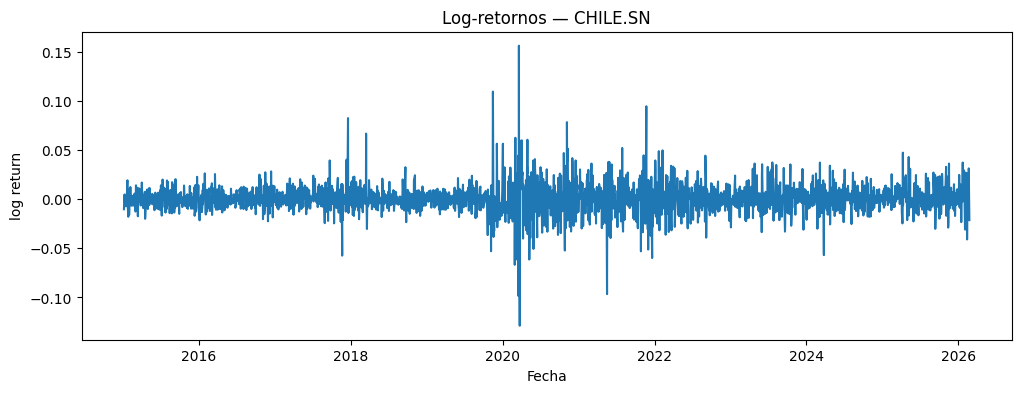

In [4]:
# ================================
# BLOQUE 1 — PLOTS (VISUAL RÁPIDO)
# ================================
plt.figure(figsize=(12,4))
plt.plot(price)
plt.title(f"Precio ({price_col}) — {ticker}")
plt.xlabel("Fecha"); plt.ylabel("Precio")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(log_ret)
plt.title(f"Log-retornos — {ticker}")
plt.xlabel("Fecha"); plt.ylabel("log return")
plt.show()


## BLOQUE 1B (Opcional) — Descomposición estacional

Solo para exploración visual; no es requisito para ARIMA financiero en precios.

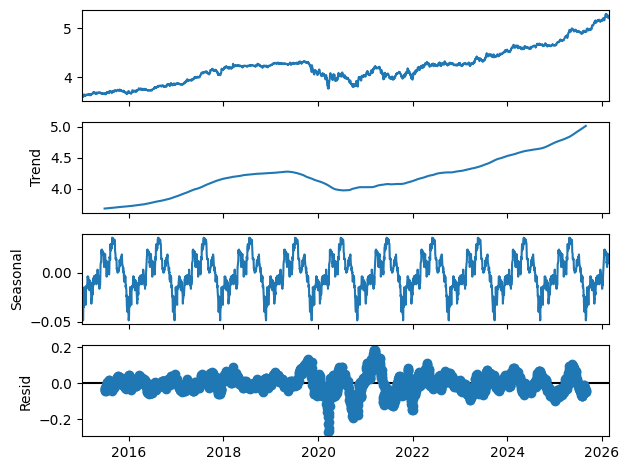

In [5]:
# ================================
# DESCOMPOSICIÓN (OPCIONAL)
# ================================
log_price_b = np.log(price.asfreq("B")).ffill().dropna()

decomp = sm.tsa.seasonal_decompose(log_price_b, model="additive", period=252)
decomp.plot()
plt.show()


## BLOQUE 2 — Estacionariedad (ADF)

En finanzas:
- **Precios** suelen NO ser estacionarios (random walk)
- **Retornos** suelen ser más cercanos a estacionarios

Aquí aplicamos ADF para confirmar.

In [6]:
def adf_test(series: pd.Series, name: str):
    result = adfuller(series.dropna())
    stat, pval = result[0], result[1]
    print(f"\nADF Test: {name}")
    print(f"ADF Statistic : {stat:.4f}")
    print(f"p-value       : {pval:.6f}")
    if pval < 0.05:
        print("→ Serie estacionaria")
    else:
        print("→ Serie NO estacionaria")

adf_test(price, "Precio ({price_col})")
adf_test(log_ret, "Log-retornos")



ADF Test: Precio ({price_col})
ADF Statistic : 3.3047
p-value       : 1.000000
→ Serie NO estacionaria

ADF Test: Log-retornos
ADF Statistic : -15.2126
p-value       : 0.000000
→ Serie estacionaria


## BLOQUE 3 — Identificación (ACF / PACF)

Guía visual para sugerir órdenes (p, q) en series estacionarias (usamos **log_ret**).

<Figure size 1000x400 with 0 Axes>

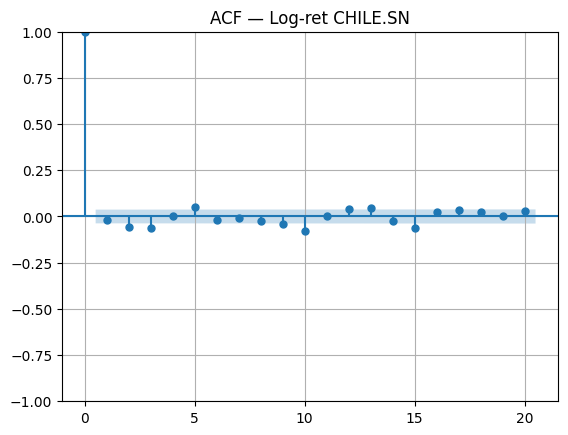

<Figure size 1000x400 with 0 Axes>

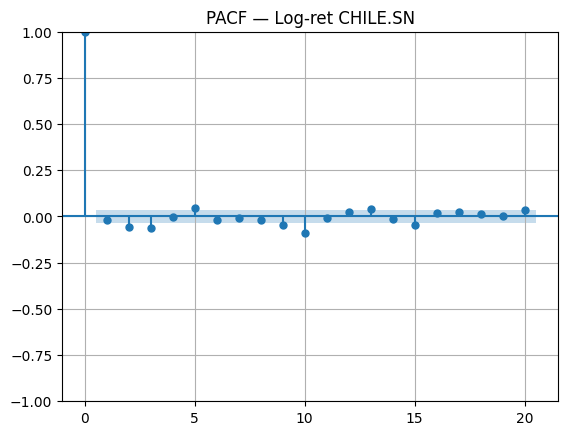

In [7]:
plt.figure(figsize=(10,4))
plot_acf(log_ret, lags=20)
plt.title(f"ACF — Log-ret {ticker}")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plot_pacf(log_ret, lags=20, method="ywm")
plt.title(f"PACF — Log-ret {ticker}")
plt.grid(True)
plt.show()

## BLOQUE 4 — Estimación ARIMA automática (auto_arima) sobre log-ret

Usamos **AIC** para seleccionar (p,d,q) con búsqueda stepwise.

In [8]:
model_p = pm.auto_arima(
    log_ret,
    start_p=0, start_q=0,
    max_p=5, max_q=5,
    d=None,              # <-- IMPORTANTE: que el modelo encuentre d
    seasonal=False,
    stepwise=True,
    trace=True,
    information_criterion="aic",
    suppress_warnings=True
)

print(model_p.summary())
print("Best order (precio):", model_p.order)



Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-15606.363, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-15605.191, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-15605.279, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-15603.237, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-15608.776, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-15607.769, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-15607.884, Time=0.27 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-15604.777, Time=0.19 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.266 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2773
Model:                        SARIMAX   Log Likelihood                7806.388
Date:                Mon, 23 Feb 2026   AIC                         -15608.776
Time:               

## BLOQUE 5 — Diagnóstico de residuos

Objetivo: que los residuos se comporten como **ruido blanco**.

Hacemos:
- Serie de residuos
- Histograma
- ACF de residuos
- QQ-plot
- Test Ljung-Box (p-value > 0.05 es buena señal)

In [9]:
residuos = pd.Series(
    model_p.resid(),
    index=log_price.index[-len(model_p.resid()):]
).dropna()


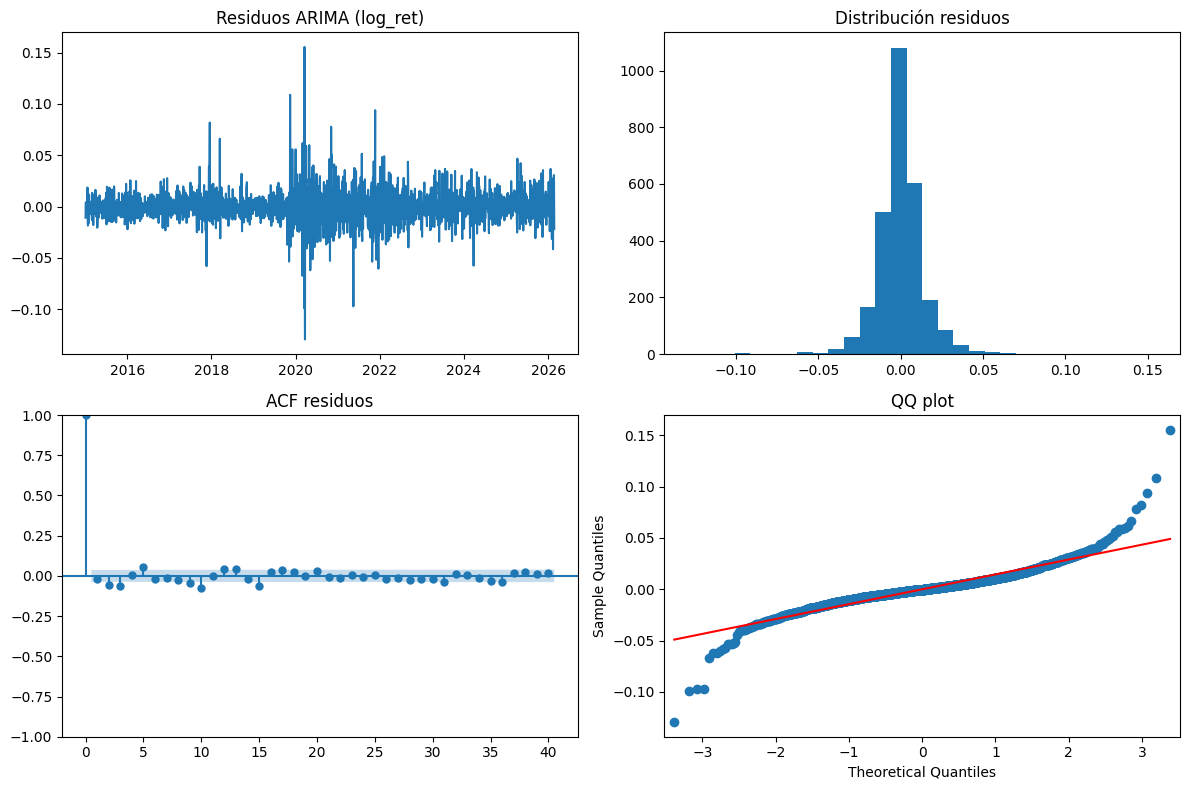

In [10]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(residuos)
plt.title("Residuos ARIMA (log_ret)")

plt.subplot(2,2,2)
plt.hist(residuos, bins=30)
plt.title("Distribución residuos")

plt.subplot(2,2,3)
sm.graphics.tsa.plot_acf(residuos, lags=40, ax=plt.gca())
plt.title("ACF residuos")

plt.subplot(2,2,4)
sm.qqplot(residuos, line='s', ax=plt.gca())
plt.title("QQ plot")

plt.tight_layout()
plt.show()

In [11]:
lj = acorr_ljungbox(residuos, lags=[10, 20, 30], return_df=True)
lj

,lb_stat,lb_pvalue
10,52.871789,7.865456e-08
20,83.555495,9.702616e-10
30,90.630018,5.269189e-08


# **3. Volatilidad Condicional: ARCH/GARCH**


## Modelamiento Volatilidad Arch - Garch

# BLOQUE 6 — Hechos estilizados: ¿hay clustering de volatilidad?

<Figure size 1200x400 with 0 Axes>

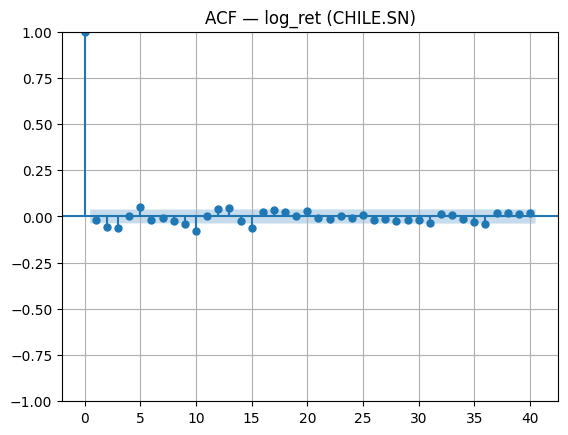

<Figure size 1200x400 with 0 Axes>

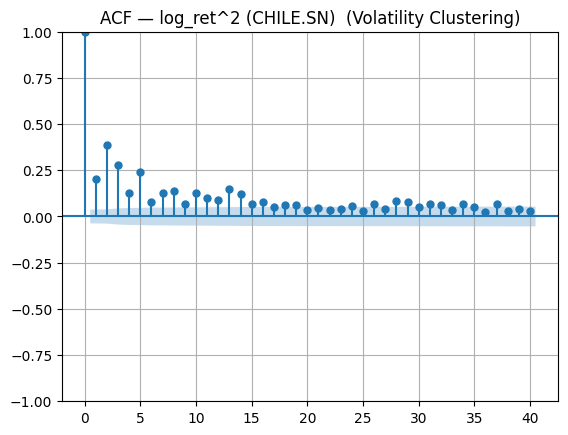

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# ACF retornos
plt.figure(figsize=(12,4))
plot_acf(log_ret.dropna(), lags=40)
plt.title(f"ACF — log_ret ({ticker})")
plt.grid(True)
plt.show()

# ACF retornos^2 (clustering)
plt.figure(figsize=(12,4))
plot_acf((log_ret.dropna()**2), lags=40)
plt.title(f"ACF — log_ret^2 ({ticker})  (Volatility Clustering)")
plt.grid(True)
plt.show()

# BLOQUE 7 — Test formal: ARCH-LM (¿hay heterocedasticidad condicional?)

In [13]:
from statsmodels.stats.diagnostic import het_arch

# Opción A: test en retornos
arch_test_ret = het_arch(log_ret.dropna(), nlags=12)
print("ARCH-LM en log_ret")
print(f"LM Stat: {arch_test_ret[0]:.4f} | p-value: {arch_test_ret[1]:.6f}")

# Opción B: test en residuos ARIMA 
arch_test_res = het_arch(residuos.dropna(), nlags=12)
print("\nARCH-LM en residuos ARIMA")
print(f"LM Stat: {arch_test_res[0]:.4f} | p-value: {arch_test_res[1]:.6f}")


ARCH-LM en log_ret
LM Stat: 580.1334 | p-value: 0.000000

ARCH-LM en residuos ARIMA
LM Stat: 589.1424 | p-value: 0.000000


In [14]:
from arch import arch_model

eps = residuos.dropna()

arch1 = arch_model(
    eps,
    mean="Zero",
    vol="ARCH",
    p=1,
    dist="t"
)

arch1_fit = arch1.fit(disp="off")
print(arch1_fit.summary())

                           Zero Mean - ARCH Model Results                           
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                             ARCH   Log-Likelihood:                8274.69
Distribution:      Standardized Student's t   AIC:                          -16543.4
Method:                  Maximum Likelihood   BIC:                          -16525.6
                                              No. Observations:                 2773
Date:                      Mon, Feb 23 2026   Df Residuals:                     2773
Time:                              18:01:35   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omeg

# BLOQUE 8 — Modelo base: GARCH(1,1) sobre residuos del ARIMA (enfoque “profesional”)

In [15]:
! pip install arch --quiet


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
from arch import arch_model

eps = residuos.dropna()

garch11 = arch_model(
    eps,
    mean="Zero",        # porque eps ya son residuos (media ~ 0)
    vol="GARCH",
    p=1, q=1,
    dist="t"            # t-student suele funcionar mejor en finanzas (colas pesadas)
)

garch11_fit = garch11.fit(disp="off")
print(garch11_fit.summary())

                          Zero Mean - GARCH Model Results                           
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                8443.35
Distribution:      Standardized Student's t   AIC:                          -16878.7
Method:                  Maximum Likelihood   BIC:                          -16855.0
                                              No. Observations:                 2773
Date:                      Mon, Feb 23 2026   Df Residuals:                     2773
Time:                              18:01:36   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omeg

# BLOQUE 9 — Extraer y graficar volatilidad condicional (σ_t)

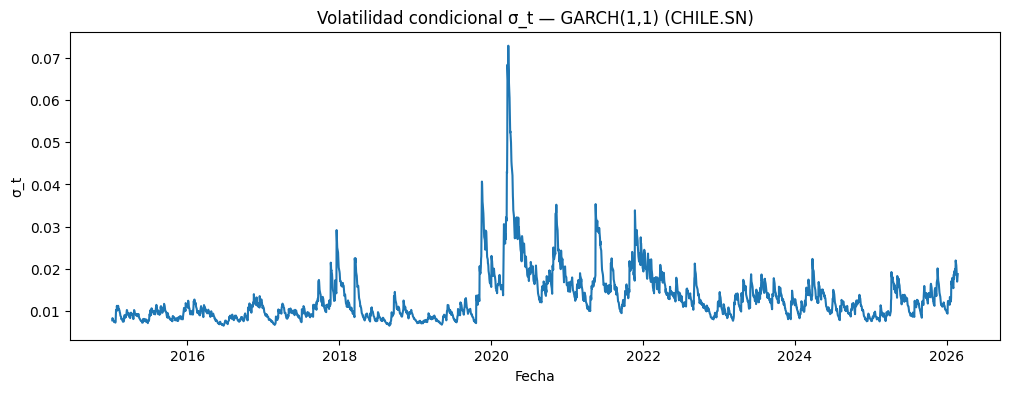

In [17]:
import matplotlib.pyplot as plt

cond_vol = garch11_fit.conditional_volatility  # sigma_t

plt.figure(figsize=(12,4))
plt.plot(cond_vol)
plt.title(f"Volatilidad condicional σ_t — GARCH(1,1) ({ticker})")
plt.xlabel("Fecha"); plt.ylabel("σ_t")
plt.show()


# BLOQUE 10 — Comparación: volatilidad condicional vs histórica (rolling)

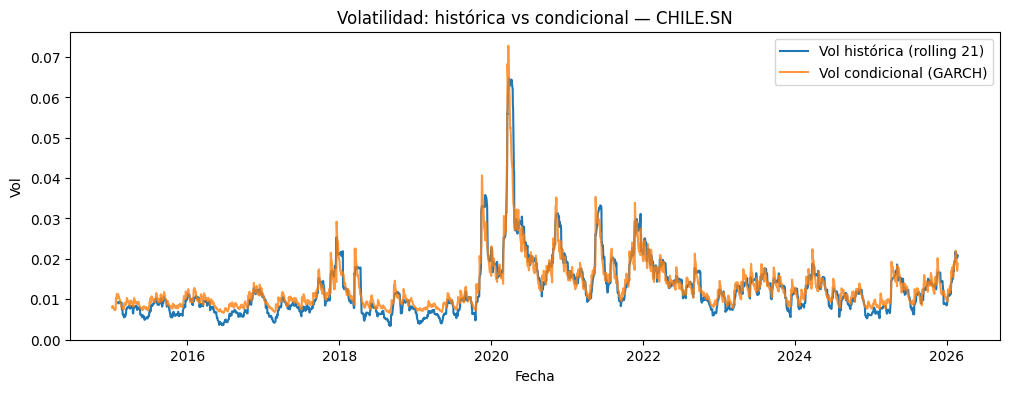

In [18]:
# Vol histórica rolling (21 días hábiles)
vol_hist = log_ret.dropna().rolling(21).std()

plt.figure(figsize=(12,4))
plt.plot(vol_hist, label="Vol histórica (rolling 21)")
plt.plot(cond_vol, label="Vol condicional (GARCH)", alpha=0.8)
plt.title(f"Volatilidad: histórica vs condicional — {ticker}")
plt.xlabel("Fecha"); plt.ylabel("Vol")
plt.legend()
plt.show()


# BLOQUE 11 — Diagnóstico rápido del GARCH (residuos estandarizados)

<Figure size 1200x400 with 0 Axes>

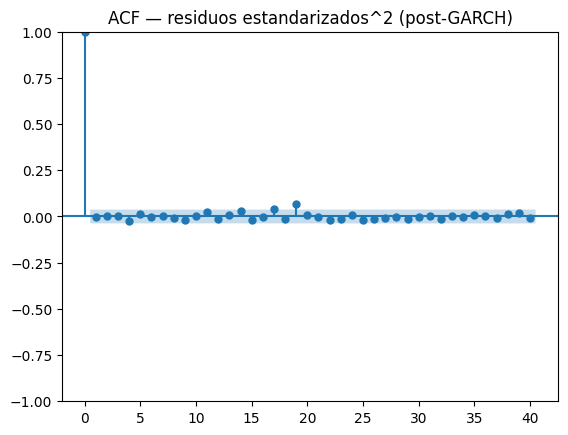

,lb_stat,lb_pvalue
10,3.263152,0.974535
20,26.862916,0.139165
30,30.485976,0.440978


In [19]:

# Residuo estandarizado z_t = eps_t / sigma_t
std_resid = garch11_fit.std_resid

# ACF de z_t^2 
plt.figure(figsize=(12,4))
plot_acf((std_resid**2), lags=40)
plt.title("ACF — residuos estandarizados^2 (post-GARCH)")
plt.show()

# Ljung-Box en z_t^2
lb = acorr_ljungbox(std_resid**2, lags=[10, 20, 30], return_df=True)
lb

# BLOQUE 12 — Modelos de Volatilidad Asimétrica: EGARCH y GJR-GARCH (Introspección + Comparación)
🎯 Objetivo del bloque

Explorar alternativas a GARCH(1,1) cuando sospechamos que el mercado reacciona distinto ante noticias malas vs buenas (leverage effect), y comparar modelos con AIC/BIC + diagnóstico.

🅰 Punto A — EGARCH(1,1)
¿De qué trata?

EGARCH (Exponential GARCH) modela la volatilidad en escala logarítmica.

Diferencias clave vs GARCH

✅ Permite asimetría con γ (leverage effect)
✅ Asegura σ² > 0 automáticamente (porque modela log σ²)
✅ Maneja mejor colas y volatilidad extrema en algunos activos

Interpretación del parámetro γ:

γ < 0 (típico en equity): shocks negativos aumentan más la vol que shocks positivos.

                          Zero Mean - EGARCH Model Results                          
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:                8448.47
Distribution:      Standardized Student's t   AIC:                          -16888.9
Method:                  Maximum Likelihood   BIC:                          -16865.2
                                              No. Observations:                 2773
Date:                      Mon, Feb 23 2026   Df Residuals:                     2773
Time:                              18:01:36   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega  

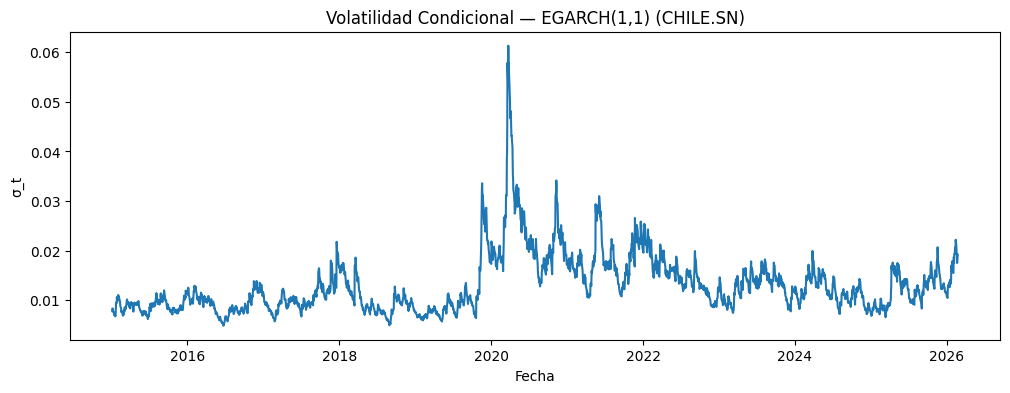

In [20]:
from arch import arch_model
import matplotlib.pyplot as plt

eps = residuos.dropna()

# EGARCH(1,1)
model_egarch = arch_model(
    eps,
    mean="Zero",
    vol="EGARCH",
    p=1, q=1,
    dist="t"   # colas pesadas típicas en finanzas
)

res_egarch = model_egarch.fit(disp="off")
print(res_egarch.summary())

# Volatilidad condicional ajustada
vol_egarch = res_egarch.conditional_volatility

plt.figure(figsize=(12,4))
plt.plot(vol_egarch)
plt.title(f"Volatilidad Condicional — EGARCH(1,1) ({ticker})")
plt.xlabel("Fecha"); plt.ylabel("σ_t")
plt.show()


🅱 Punto B — GJR-GARCH(1,1)
¿De qué trata?

GJR-GARCH agrega un término que se activa si el shock fue negativo.

Diferencias clave vs GARCH

✅ Asimetría explícita: si ε<0, el shock pesa más
✅ Muy usado en equity y riesgo porque es intuitivo
🔸 Requiere restricciones para asegurar positividad/estabilidad

Interpretación del parámetro γ (en GJR):

γ > 0: shocks negativos aumentan más la vol (leverage effect)

                        Zero Mean - GJR-GARCH Model Results                         
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                8442.22
Distribution:      Standardized Student's t   AIC:                          -16874.4
Method:                  Maximum Likelihood   BIC:                          -16844.8
                                              No. Observations:                 2773
Date:                      Mon, Feb 23 2026   Df Residuals:                     2773
Time:                              18:01:37   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omeg

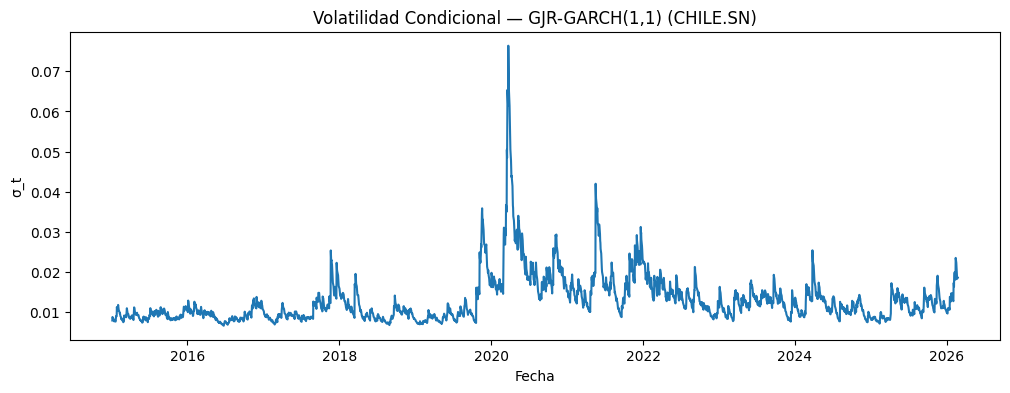

In [21]:
from arch import arch_model
import matplotlib.pyplot as plt

eps = residuos.dropna()

# GJR-GARCH(1,1): en arch se implementa como GARCH con o=1 (término asimétrico)
model_gjr = arch_model(
    eps,
    mean="Zero",
    vol="GARCH",
    p=1, o=1, q=1,
    dist="t"
)

res_gjr = model_gjr.fit(disp="off")
print(res_gjr.summary())

# Volatilidad condicional ajustada
vol_gjr = res_gjr.conditional_volatility

plt.figure(figsize=(12,4))
plt.plot(vol_gjr)
plt.title(f"Volatilidad Condicional — GJR-GARCH(1,1) ({ticker})")
plt.xlabel("Fecha"); plt.ylabel("σ_t")
plt.show()


# BLOQUE 13 — Graficos de distintas volatilidades

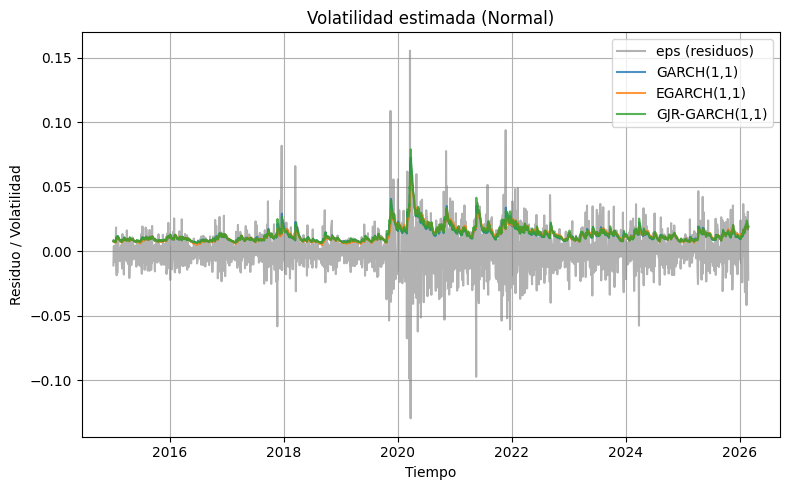

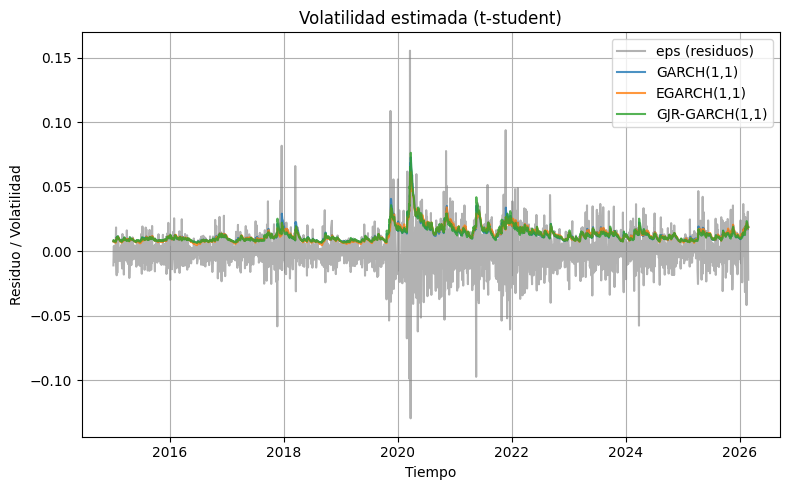

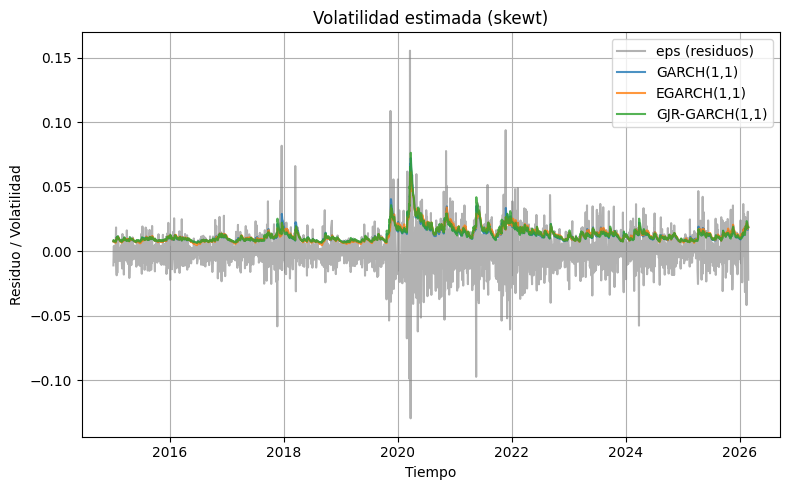

In [22]:
from arch import arch_model

# === Funciones para eps (residuos ARIMA) ===
def fit_garch(eps, dist='normal'):
    model = arch_model(eps, mean="Zero", vol='GARCH', p=1, q=1, dist=dist)
    results = model.fit(disp='off')
    return results

def fit_egarch(eps, dist='normal'):
    model = arch_model(eps, mean="Zero", vol='EGARCH', p=1, q=1, dist=dist)
    results = model.fit(disp='off')
    return results

def fit_gjr_garch(eps, dist='normal'):
    model = arch_model(eps, mean="Zero", vol='GARCH', p=1, o=1, q=1, dist=dist)
    results = model.fit(disp='off')
    return results

#########################################################################################
import pandas as pd
import matplotlib.pyplot as plt

eps = residuos.dropna()

# 1) Ajuste con Normal
res_garch_n  = fit_garch(eps, dist='normal')
res_egarch_n = fit_egarch(eps, dist='normal')
res_gjr_n    = fit_gjr_garch(eps, dist='normal')

# 2) Ajuste con t-student
res_garch_t  = fit_garch(eps, dist='t')
res_egarch_t = fit_egarch(eps, dist='t')
res_gjr_t    = fit_gjr_garch(eps, dist='t')

# 3) Ajuste con skewt (asimétrica)
res_garch_s  = fit_garch(eps, dist='skewt')
res_egarch_s = fit_egarch(eps, dist='skewt')
res_gjr_s    = fit_gjr_garch(eps, dist='skewt')

########################################################################################

def plot_vols(eps, res_garch, res_egarch, res_gjr, title=""):
    df = pd.DataFrame({
        "eps": eps,
        "GARCH(1,1)": res_garch.conditional_volatility,
        "EGARCH(1,1)": res_egarch.conditional_volatility,
        "GJR-GARCH(1,1)": res_gjr.conditional_volatility
    })

    plt.figure(figsize=(8,5))
    plt.plot(df["eps"], label="eps (residuos)", color="gray", alpha=0.6)
    plt.plot(df["GARCH(1,1)"], label="GARCH(1,1)", alpha=0.8)
    plt.plot(df["EGARCH(1,1)"], label="EGARCH(1,1)", alpha=0.8)
    plt.plot(df["GJR-GARCH(1,1)"], label="GJR-GARCH(1,1)", alpha=0.8)
    plt.title(title)
    plt.xlabel("Tiempo")
    plt.ylabel("Residuo / Volatilidad")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#########################################################################################

plot_vols(eps, res_garch_n, res_egarch_n, res_gjr_n, title="Volatilidad estimada (Normal)")
plot_vols(eps, res_garch_t, res_egarch_t, res_gjr_t, title="Volatilidad estimada (t-student)")
plot_vols(eps, res_garch_s, res_egarch_s, res_gjr_s, title="Volatilidad estimada (skewt)")


# BLOQUE 14 — Forecast de Volatilidad

,h,"GARCH(1,1)","EGARCH(1,1)","GJR-GARCH(1,1)"
0,1,0.019065,0.019819,0.019488
1,2,0.018964,0.019802,0.019338
2,3,0.018844,0.019790,0.019281
3,4,0.018783,0.019739,0.019217
4,5,0.018715,0.019693,0.019150
5,6,0.018614,0.019640,0.019115
6,7,0.018542,0.019580,0.018979
7,8,0.018463,0.019508,0.018905
8,9,0.018400,0.019492,0.018820
9,10,0.018309,0.019469,0.018743


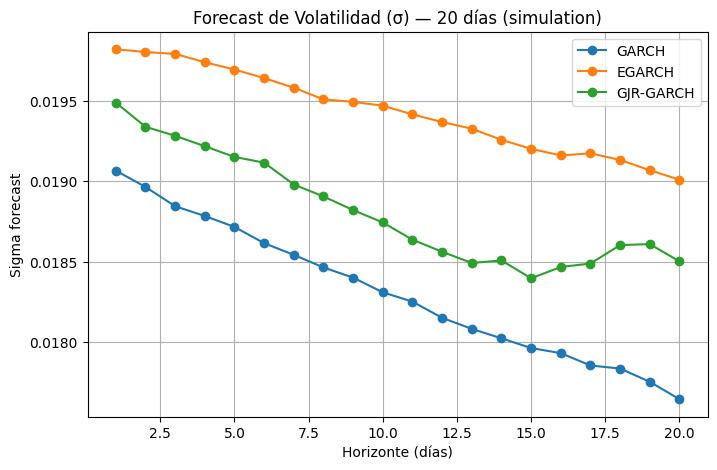

In [23]:
h = 20
n_sim = 5000  

# Forecast (multi-step) usando simulación
fcast_garch  = garch11_fit.forecast(horizon=h, method="simulation", simulations=n_sim, reindex=False)
fcast_egarch = res_egarch.forecast(horizon=h, method="simulation", simulations=n_sim, reindex=False)
fcast_gjr    = res_gjr.forecast(horizon=h, method="simulation", simulations=n_sim, reindex=False)

# Extraer sigma forecast: sqrt(var) de la última fila
sigma_garch  = np.sqrt(fcast_garch.variance.values[-1])
sigma_egarch = np.sqrt(fcast_egarch.variance.values[-1])
sigma_gjr    = np.sqrt(fcast_gjr.variance.values[-1])

df_forecast = pd.DataFrame({
    "h": np.arange(1, h+1),
    "GARCH(1,1)": sigma_garch,
    "EGARCH(1,1)": sigma_egarch,
    "GJR-GARCH(1,1)": sigma_gjr
})

display(df_forecast)

plt.figure(figsize=(8,5))
plt.plot(df_forecast["h"], df_forecast["GARCH(1,1)"], marker="o", label="GARCH")
plt.plot(df_forecast["h"], df_forecast["EGARCH(1,1)"], marker="o", label="EGARCH")
plt.plot(df_forecast["h"], df_forecast["GJR-GARCH(1,1)"], marker="o", label="GJR-GARCH")

plt.title(f"Forecast de Volatilidad (σ) — {h} días (simulation)")
plt.xlabel("Horizonte (días)")
plt.ylabel("Sigma forecast")
plt.legend()
plt.grid(True)
plt.show()

# BLOQUE 15 — Value at Risk (VaR): Enfoques Comparativos

El Value at Risk (VaR) mide la pérdida máxima esperada en un horizonte dado
con un nivel de confianza determinado.

En este bloque implementaremos tres enfoques clásicos:

1. VaR Paramétrico (Modelo condicional ARIMA + GARCH)
2. VaR Histórico
3. VaR Monte Carlo
4. Extensión: Monte Carlo Multivariado (Cholesky)

El objetivo es comparar sus fundamentos, supuestos y diferencias.

## 15.1 VaR Paramétrico Condicional

Se basa en:

VaR_t = μ̂_t + q_α · σ̂_t

Ventajas:
- Captura volatilidad dinámica
- Permite colas pesadas (t-student)

Desventajas:
- Depende del modelo
- Sensible a mala especificación

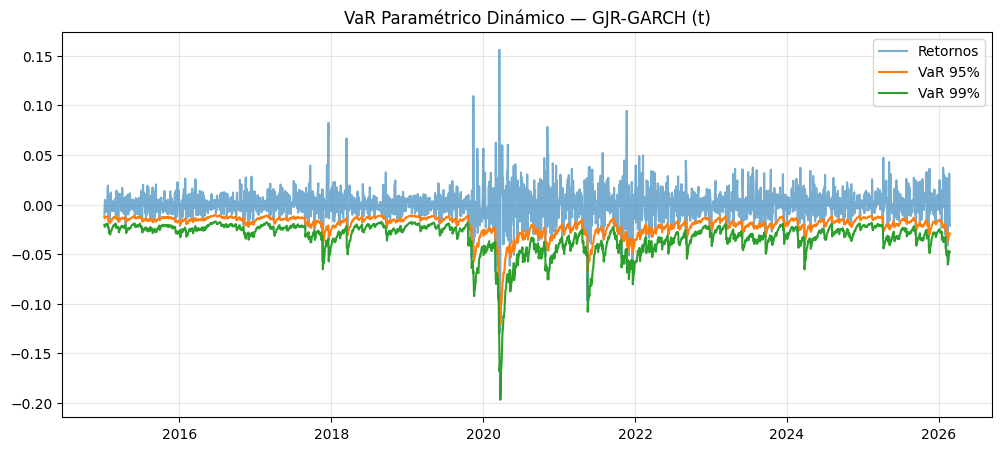

,r,mu,sigma,VaR_95,VaR_99
Date,,,,,
2026-02-17,-0.006197,0.0,0.021188,-0.033505,-0.054573
2026-02-18,-0.008087,0.0,0.020153,-0.031868,-0.051907
2026-02-19,-0.001800,0.0,0.019310,-0.030535,-0.049735
2026-02-20,0.031278,0.0,0.018253,-0.028864,-0.047014
2026-02-23,-0.021391,0.0,0.018561,-0.029351,-0.047807


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, t

# ----------------------------
# 1) Definir el índice "válido" para VaR
# ----------------------------
# el GARCH se ajusta sobre eps = residuos.dropna()
# Para comparar r_t vs VaR_t de forma correcta
try:
    idx = residuos.dropna().index
except Exception:
    idx = log_ret.dropna().index

# ----------------------------
# 2) Base dataframe con retornos y media condicional
# ----------------------------
df_var = pd.DataFrame(index=idx)

# Retornos observados
df_var["r"] = log_ret.reindex(idx).astype(float)

# Media condicional (ARIMA)
try:
    df_var["mu"] = arima_res.fittedvalues.reindex(idx).astype(float)
except Exception:
    df_var["mu"] = 0.0

df_var["mu"] = df_var["mu"].fillna(0.0)

# ----------------------------
# 3) Volatilidad condicional: modelo seleccionado
# ----------------------------
# Modelo final 
garch_res = res_gjr_t

# sigma_t
sigma_series = pd.Series(garch_res.conditional_volatility, index=idx, name="sigma")
df_var["sigma"] = sigma_series

# Limpieza final
df_var = df_var.dropna(subset=["r", "mu", "sigma"]).copy()

# ----------------------------
# 4) Cuantiles: t-Student estandarizada a var=1
# ----------------------------
# Nota: la t estándar tiene Var = nu/(nu-2). Para shocks con Var=1:
# q_std = t_ppf(alpha, nu) * sqrt((nu-2)/nu)
if "nu" not in garch_res.params.index:
    raise KeyError("No encontré 'nu' en garch_res.params. Revisa garch_res.params.index")

nu = float(garch_res.params["nu"])

def q_student_std(alpha: float) -> float:
    return t.ppf(alpha, df=nu) * np.sqrt((nu - 2) / nu)

alphas = {"VaR_95": 0.05, "VaR_99": 0.01}

for name, a in alphas.items():
    df_var[name] = df_var["mu"] + q_student_std(a) * df_var["sigma"]

# ----------------------------
# 5) Gráfico (retornos vs VaR)
# ----------------------------
plt.figure(figsize=(12,5))
plt.plot(df_var.index, df_var["r"], label="Retornos", alpha=0.6)
plt.plot(df_var.index, df_var["VaR_95"], label="VaR 95%")
plt.plot(df_var.index, df_var["VaR_99"], label="VaR 99%")
plt.title("VaR Paramétrico Dinámico — GJR-GARCH (t)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

df_var.tail()


## 15.2 VaR Histórico

El VaR histórico no asume distribución paramétrica.

Se calcula directamente como el percentil empírico
de los retornos pasados.

VaR_α = Percentil_α(r_t)

VaR Histórico 95%: -0.020999864597189877
VaR Histórico 99%: -0.03580654596818306


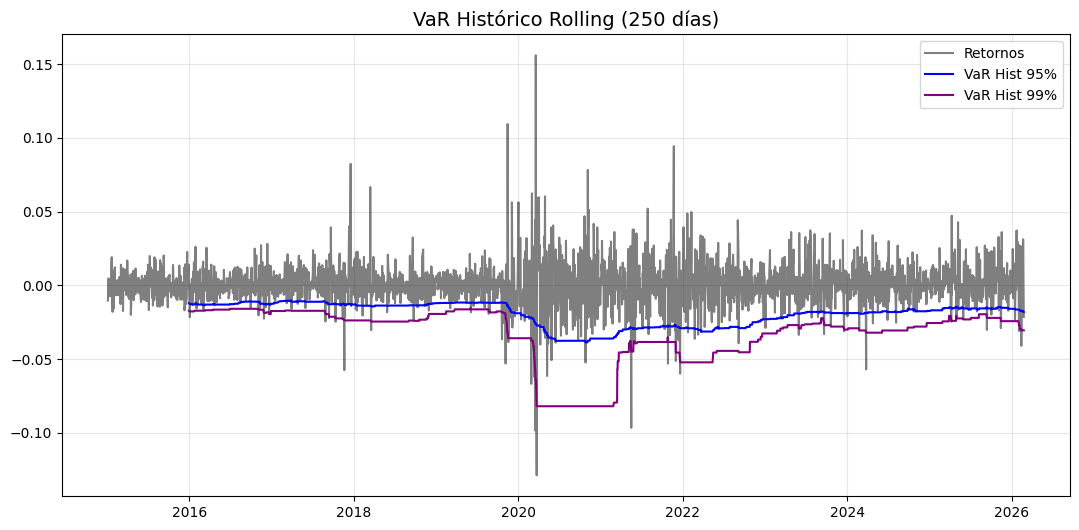

In [25]:
# VaR histórico global
var_hist_95 = np.percentile(log_ret.dropna(), 5)
var_hist_99 = np.percentile(log_ret.dropna(), 1)

print("VaR Histórico 95%:", var_hist_95)
print("VaR Histórico 99%:", var_hist_99)

# Rolling 250 días (~1 año bursátil)
window = 250

df_var["VaR_hist_95"] = df_var["r"].rolling(window).quantile(0.05)
df_var["VaR_hist_99"] = df_var["r"].rolling(window).quantile(0.01)

df_var[["r", "VaR_hist_95", "VaR_hist_99"]].dropna().tail()

plt.figure(figsize=(13,6))

plt.plot(df_var.index, df_var["r"], 
         color="black", alpha=0.5, label="Retornos")

plt.plot(df_var.index, df_var["VaR_hist_95"], 
         color="blue", linewidth=1.5, label="VaR Hist 95%")

plt.plot(df_var.index, df_var["VaR_hist_99"], 
         color="purple", linewidth=1.5, label="VaR Hist 99%")

plt.title("VaR Histórico Rolling (250 días)", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 15.3 VaR Monte Carlo (Univariado)

Se simulan N escenarios para el retorno futuro:

r_{t+1} = μ̂_t + σ̂_t · ε

donde ε sigue la distribución estimada (normal o t).

El VaR se calcula como el percentil de la distribución simulada.

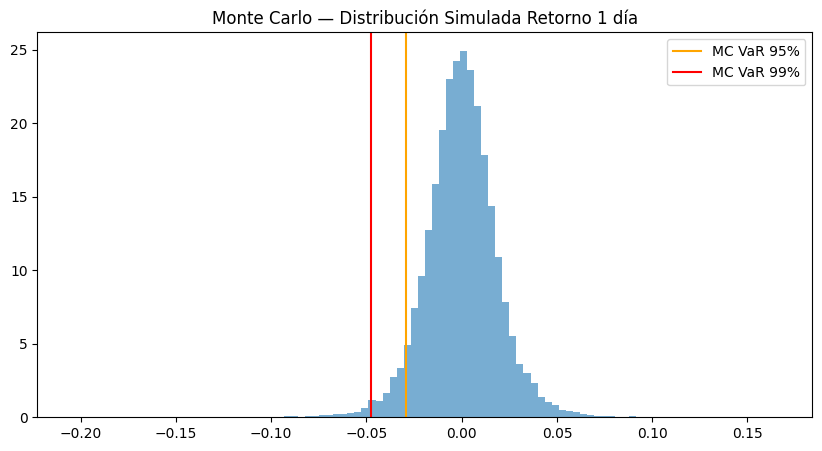

Monte Carlo VaR 95%: -0.029318893369301807
Monte Carlo VaR 99%: -0.04748455009014987


In [26]:
# ==============================
# Monte Carlo VaR (1 día)
# ==============================
N = 20000

last_mu = df_var["mu"].iloc[-1]
last_sigma = df_var["sigma"].iloc[-1]
nu = garch_res.params["nu"]

# shocks t estandarizados
shocks = t.rvs(df=nu, size=N) * np.sqrt((nu-2)/nu)

sim_returns = last_mu + last_sigma * shocks

mc_var_95 = np.percentile(sim_returns, 5)
mc_var_99 = np.percentile(sim_returns, 1)

plt.figure(figsize=(10,5))
plt.hist(sim_returns, bins=100, density=True, alpha=0.6)
plt.axvline(mc_var_95, color="orange", label="MC VaR 95%")
plt.axvline(mc_var_99, color="red", label="MC VaR 99%")

plt.title("Monte Carlo — Distribución Simulada Retorno 1 día")
plt.legend()
plt.show()

print("Monte Carlo VaR 95%:", mc_var_95)
print("Monte Carlo VaR 99%:", mc_var_99)

## 15.4 Monte Carlo Multivariado (Cholesky)

Cuando trabajamos con portafolios, necesitamos simular
retornos correlacionados.

Si Σ es la matriz de covarianza, podemos usar
la descomposición de Cholesky:

Σ = L L'

Simulamos:

Z ~ N(0,I)
ε = L Z

Así obtenemos shocks correlacionados.

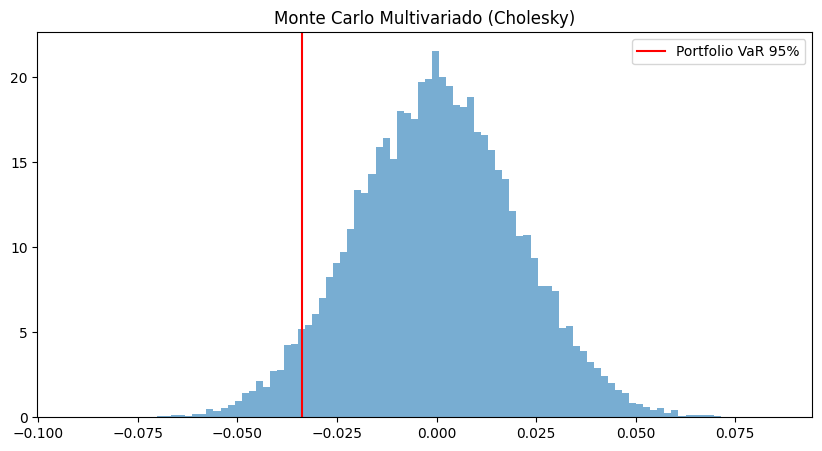

Portfolio VaR 95%: -0.0336836586994108


In [27]:
# ==============================
# Monte Carlo Multivariado (Ejemplo)
# ==============================

# Supongamos retornos de dos activos
returns_matrix = pd.concat([log_ret, log_ret.shift(1)], axis=1).dropna()
returns_matrix.columns = ["Asset1", "Asset2"]

cov_matrix = returns_matrix.cov().values
L = np.linalg.cholesky(cov_matrix)

N = 20000
Z = np.random.normal(size=(2, N))
correlated_shocks = L @ Z

sim_portfolio = correlated_shocks.sum(axis=0)

portfolio_var_95 = np.percentile(sim_portfolio, 5)

plt.figure(figsize=(10,5))
plt.hist(sim_portfolio, bins=100, density=True, alpha=0.6)
plt.axvline(portfolio_var_95, color="red", label="Portfolio VaR 95%")

plt.title("Monte Carlo Multivariado (Cholesky)")
plt.legend()
plt.show()

print("Portfolio VaR 95%:", portfolio_var_95)

## 15.5 Comparación de Enfoques

| Método        | Supuestos | Dinámico | Pros | Contras |
|--------------|----------|----------|------|---------|
| Paramétrico  | Sí       | Sí       | Flexible | Depende del modelo |
| Histórico    | No       | No       | Simple | No captura cambios estructurales |
| Monte Carlo  | Sí       | Sí       | Muy flexible | Computacionalmente intensivo |

En la práctica bancaria, el VaR paramétrico condicional
es común en market risk, mientras que Monte Carlo
es estándar para portafolios complejos.

# BLOQUE 16 — Backtesting del VaR (Validación Cuantitativa)

## 16.1 ¿Qué es backtesting y por qué se hace?

El VaR es una predicción probabilística:
- VaR 99% significa que esperamos violaciones ~1% de los días.
- VaR 95% significa violaciones ~5% de los días.

**Backtesting** es comparar el VaR calculado con los retornos realmente observados para verificar si el modelo:

1) **Tiene la cobertura correcta** (frecuencia de violaciones ≈ α)  
2) **No tiene clustering de violaciones** (violaciones independientes en el tiempo)

En la práctica cuant (bancos/AFPs/mesas), backtesting responde:
- ¿El VaR subestima o sobreestima riesgo?
- ¿Las violaciones ocurren de forma aleatoria (como debería) o se agrupan (modelo mal especificado)?
- ¿El modelo reacciona suficientemente rápido en shocks?

---

## 16.2 Qué buscamos (criterios profesionales)

### A) Cobertura incondicional (Kupiec)
Evalúa si el porcentaje observado de violaciones coincide con el porcentaje esperado α.

- H0: P(violación) = α  
- Si rechazamos H0 → VaR está mal calibrado (muy conservador o subestima riesgo)

### B) Independencia de violaciones (Christoffersen)
Evalúa si las violaciones son independientes (no deberían agruparse).

- H0: las violaciones no dependen de la violación previa  
- Si rechazamos H0 → hay **clustering** (típico cuando la volatilidad cambia rápido y el modelo no la capta)

### C) Cobertura condicional (Christoffersen completo)
Combina ambas:
- Cobertura correcta + Independencia correcta

---

## 16.3 Interpretación cuant (cómo lo usan en la realidad)

Un VaR "bueno" típicamente:
- No rechaza Kupiec (p-value alto)
- No rechaza Independencia (p-value alto)
- No rechaza Cobertura condicional

Además se revisa:
- Número esperado vs observado de violaciones
- Gráfico de violaciones en el tiempo
- Si las violaciones se concentran en crisis (normal) pero sin clustering excesivo

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2

# ============================================================
# Helpers
# ============================================================

def make_hits(df, var_col, r_col="r"):
    """
    Hit = 1 si hay violación (retorno < VaR), 0 si no.
    Devuelve serie alineada y sin NaN.
    """
    tmp = df[[r_col, var_col]].dropna().copy()
    hit = (tmp[r_col] < tmp[var_col]).astype(int)
    hit.name = f"hit_{var_col}"
    return hit

def kupiec_test(hit, alpha):
    """
    Kupiec (Unconditional Coverage) LRuc test.
    H0: P(hit=1) = alpha
    """
    x = int(hit.sum())
    T = int(hit.count())
    phat = x / T if T > 0 else np.nan

    # evitar logs inválidos si x=0 o x=T
    eps = 1e-12
    phat_c = np.clip(phat, eps, 1 - eps)
    alpha_c = np.clip(alpha, eps, 1 - eps)

    # log-likelihoods
    ll_null = x * np.log(alpha_c) + (T - x) * np.log(1 - alpha_c)
    ll_alt  = x * np.log(phat_c)  + (T - x) * np.log(1 - phat_c)

    LRuc = -2 * (ll_null - ll_alt)
    pval = 1 - chi2.cdf(LRuc, df=1)

    return {"T": T, "x": x, "phat": phat, "LRuc": LRuc, "pvalue": pval}

def christoffersen_independence_test(hit):
    """
    Christoffersen independence test (LRind).
    H0: hits independientes (Markov de orden 0)
    Se basa en conteos de transiciones:
    N00, N01, N10, N11
    """
    h = hit.dropna().astype(int).values
    if len(h) < 2:
        return {"N00": np.nan, "N01": np.nan, "N10": np.nan, "N11": np.nan,
                "LRind": np.nan, "pvalue": np.nan}

    h_lag = h[:-1]
    h_cur = h[1:]

    N00 = int(((h_lag == 0) & (h_cur == 0)).sum())
    N01 = int(((h_lag == 0) & (h_cur == 1)).sum())
    N10 = int(((h_lag == 1) & (h_cur == 0)).sum())
    N11 = int(((h_lag == 1) & (h_cur == 1)).sum())

    # probabilidades condicionales
    eps = 1e-12
    pi01 = N01 / (N00 + N01) if (N00 + N01) > 0 else 0.0
    pi11 = N11 / (N10 + N11) if (N10 + N11) > 0 else 0.0

    # probabilidad incondicional
    pi = (N01 + N11) / (N00 + N01 + N10 + N11) if (N00 + N01 + N10 + N11) > 0 else 0.0

    # clip para logs
    pi01 = float(np.clip(pi01, eps, 1 - eps))
    pi11 = float(np.clip(pi11, eps, 1 - eps))
    pi   = float(np.clip(pi,   eps, 1 - eps))

    # log-likelihoods
    ll_ind = (N00 * np.log(1 - pi01) + N01 * np.log(pi01) +
              N10 * np.log(1 - pi11) + N11 * np.log(pi11))

    ll_iid = ((N00 + N10) * np.log(1 - pi) + (N01 + N11) * np.log(pi))

    LRind = -2 * (ll_iid - ll_ind)
    pval = 1 - chi2.cdf(LRind, df=1)

    return {"N00": N00, "N01": N01, "N10": N10, "N11": N11, "LRind": LRind, "pvalue": pval}

def christoffersen_conditional_coverage(hit, alpha):
    """
    Christoffersen conditional coverage (LRcc) = LRuc + LRind
    """
    uc = kupiec_test(hit, alpha)
    ind = christoffersen_independence_test(hit)

    LRcc = uc["LRuc"] + ind["LRind"]
    pval = 1 - chi2.cdf(LRcc, df=2)

    return {"LRcc": LRcc, "pvalue": pval, "uc": uc, "ind": ind}

# ============================================================
# Backtesting para VaR 95% y 99%
# ============================================================

tests = {}

for var_col, alpha in [("VaR_95", 0.05), ("VaR_99", 0.01)]:
    hit = make_hits(df_var, var_col=var_col, r_col="r")
    cc = christoffersen_conditional_coverage(hit, alpha)

    tests[var_col] = {
        "alpha": alpha,
        "T": cc["uc"]["T"],
        "x": cc["uc"]["x"],
        "phat": cc["uc"]["phat"],
        "LRuc": cc["uc"]["LRuc"],
        "p_uc": cc["uc"]["pvalue"],
        "LRind": cc["ind"]["LRind"],
        "p_ind": cc["ind"]["pvalue"],
        "LRcc": cc["LRcc"],
        "p_cc": cc["pvalue"],
    }

results_bt = pd.DataFrame(tests).T
results_bt

,alpha,T,x,phat,LRuc,p_uc,LRind,p_ind,LRcc,p_cc
VaR_95,0.05,2773.0,128.0,0.046159,0.882835,0.347426,0.161962,0.687357,1.044797,0.593096
VaR_99,0.01,2773.0,20.0,0.007212,2.410442,0.120528,0.290700,0.589772,2.701142,0.259092


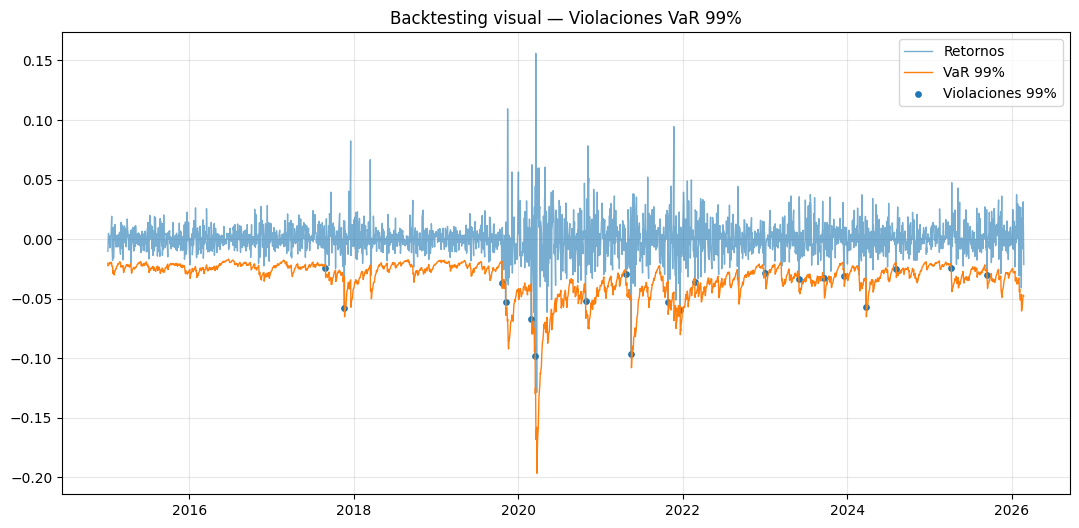

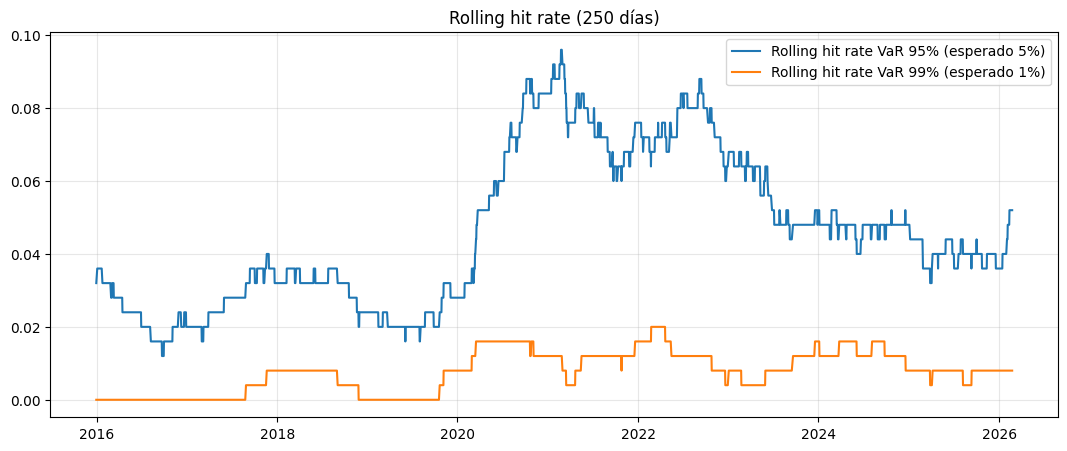

VaR_95: Observadas=128 de 2773 | Tasa=0.0462 | Esperada=0.0500
VaR_99: Observadas=20 de 2773 | Tasa=0.0072 | Esperada=0.0100


In [29]:
# ============================================================
# Gráfico de violaciones (hits) para VaR 99%
# ============================================================

hit_99 = make_hits(df_var, "VaR_99", "r")
tmp_99 = df_var[["r", "VaR_99"]].dropna().copy()
viol_99 = tmp_99[tmp_99["r"] < tmp_99["VaR_99"]]

plt.figure(figsize=(13,6))
plt.plot(tmp_99.index, tmp_99["r"], label="Retornos", alpha=0.6, linewidth=1)
plt.plot(tmp_99.index, tmp_99["VaR_99"], label="VaR 99%", linewidth=1)
plt.scatter(viol_99.index, viol_99["r"], label="Violaciones 99%", s=15)
plt.title("Backtesting visual — Violaciones VaR 99%")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ============================================================
# 16.3 Rolling hit rate (¿se acerca a 1% o 5%?)
# ============================================================

window = 250  # 1 año bursátil aprox

hit_95 = make_hits(df_var, "VaR_95", "r")

roll_95 = hit_95.rolling(window).mean()
roll_99 = hit_99.rolling(window).mean()

plt.figure(figsize=(13,5))
plt.plot(roll_95.index, roll_95.values, label="Rolling hit rate VaR 95% (esperado 5%)")
plt.plot(roll_99.index, roll_99.values, label="Rolling hit rate VaR 99% (esperado 1%)")
plt.title(f"Rolling hit rate ({window} días)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ============================================================
# 16.4 Tabla simple: esperado vs observado
# ============================================================

for var_col, alpha in [("VaR_95", 0.05), ("VaR_99", 0.01)]:
    hit = make_hits(df_var, var_col)
    T = hit.count()
    x = hit.sum()
    print(f"{var_col}: Observadas={x} de {T} | Tasa={x/T:.4f} | Esperada={alpha:.4f}")